# 在本课程中对数据集的一些处理函数

In [1]:
import hashlib
# hashlib模块的作用是根据指定的算法模式，给传入的字符串产生一个相应的校验值。主要用于文件校验和登陆验证。
import os
#os模块可以处理文件和目录这些我们日常手动需要做的操作。
import tarfile
#tarfile模块可以方便读取tar归档文件，也可以处理使用gzip和bz2压缩归档文件tar.gz和tar.gz2。与tarfile对应的是zipfile模块，zipfile是处理zip压缩的。
import requests
#requests模块是python的第三方模块,用来发送网络请求,常用于爬虫,能够完全满足基于HTTP协议的接口测试

DATA_HUB=dict()
#建立字典DATA_HUB,可以将数据集名称的字符串映射到数据集相关的二元组上
#这个二元组包含数据集的url和验证文件完整性的sha-1密钥
DATA_URL='http://d2l-data.s3-accelerate.amazonaws.com/'
#类似的数据集都托管在地址为DATA_URL的站点上

## 下载数据集

将数据集缓存在本地目录（默认情况下为./data）中， 并返回下载文件的名称。

In [2]:
def download(name,cache_dir=os.path.join('.','data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB,f"{name}不存在于{DATA_HUB}"
    url,shal_hash=DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname=os.path.join(cache_dir,url.split('/')[-1])
    if os.path.exists(fname):
        shal=hashlib.shal()
        with open(fname,'rb') as f:
            while True:
                data=f.read(1048576)
                if not data:
                    break
                shal.update(data)
        if shal.hexdigest()==shal_hash:
            return fname #命中缓存
    print(f'正在从{url}下载{fname}...')
    r=requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname

## 下载并解压缩一个zip或tar文件

In [3]:
def download_extract(name,folder=None):
    """下载并解压zip/tar文件"""
    fname=download(name)
    base_dir=os.path.dirname(fname)
    data_dir,ext=os.path.splitext(fname)
    if ext=='.zip':
        fp=zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'):
        fp=tarfile.open(fname,'r')
    else:
        assert False, '只能解压zip和tar格式的文件'
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

## 下载DATA_HUB中的所有文件

In [4]:
def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

# 运用pandas读入并处理数据

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

D:\Anaconda3\lib\site-packages\torch\cuda\__init__.py:82: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
#定义的脚本下载并缓存Kaggle房屋数据集
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [10]:
#使用pandas分别加载包含训练数据和测试数据的两个CSV文件
# train_data=pd.read_csv(download('kaggle_house_train'))
# test_data=pd.read_csv(download('kaggle_house_test'))
train_data=pd.read_csv(r'G:\动手学习深度学习\data\kaggle_house_pred_train.csv')
test_data=pd.read_csv(r'G:\动手学习深度学习\data\kaggle_house_pred_test.csv')

In [11]:
#查看训练数据集和测试数据集的形状
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

训练数据集包括1460个样本，每个样本80个特征、1个标签

测试数据集包括1459个样本，每个样本80个特征

In [12]:
#查看train中前4个数据的前4个和后2个特征，以及最后一列标签（房价）信息
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [13]:
#id列没有什么特别的意义，将其去除
train_data.iloc[:,1:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [14]:
#train中最后一列为标签列，在特征中也是不需要的
train_data.iloc[:,1:-1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [15]:
#将训练集与测试集的特征整合
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

# 数据预处理

In [16]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [17]:
#数据类型查看
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

*通过上面的代码可以观察到特征存在多种数据类型，包括object、float、int，还有一些特征是存在缺失值的。

In [18]:
#查看特征类型
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

这里往下都是对dtypes的一些理解，之前没用过这个函数

In [19]:
type(all_features.dtypes)

pandas.core.series.Series

In [20]:
all_features.dtypes.index

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [21]:
all_features.dtypes[0]

dtype('int64')

In [22]:
all_features.select_dtypes('int64')

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,856,854,0,1710,...,0,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,1262,0,0,1262,...,1,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,920,866,0,1786,...,1,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,961,756,0,1717,...,1,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,1145,1053,0,2198,...,1,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,1936,4,7,1970,1970,546,546,0,1092,...,0,0,0,0,0,0,0,0,6,2006
1455,160,1894,4,5,1970,1970,546,546,0,1092,...,0,0,24,0,0,0,0,0,4,2006
1456,20,20000,5,7,1960,1996,1224,0,0,1224,...,1,474,0,0,0,0,0,0,9,2006
1457,85,10441,5,5,1992,1992,970,0,0,970,...,0,80,32,0,0,0,0,700,7,2006


In [23]:
all_features.dtypes[0:2:10]

MSSubClass    int64
dtype: object

通过上面的type函数可以看出查看特征的函数类型为Series，及一维张量

*之前发现有些数据存在缺失值，下面的操作是为了补齐除object类型外特征的缺失值

In [24]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features=all_features.dtypes[all_features.dtypes != 'object'].index
# print(numeric_features,type(numeric_features))
all_features[numeric_features]=all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std()))

1、上面的代码将所有缺失的值替换为相应特征的平均值mean。然后，为了将所有特征放在一个共同的尺度上， 通过将特征重新缩放到零均值和单位方差(标准差std)来标准化数据。
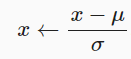
其中u和o分别表示均值和标准差

2、上面的代码运用了lambda：lambda作为一个表达式，定义了一个匿名函数。在：前的是函数中的变量，：后是函数对变量的具体操作

3、上面的代码的处理是使数据标准化，标准化数据的目的有两个:一是方便优化其次，二是因为不知道哪些特征是相关的， 所以不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

注：提到了"惩罚"一词，该词在权值衰退中出现

4、这个地方其实是要注意的，因为normalization应该统一用train set的均值和方差，这个地方由于数据特殊没有区分

5、apply函数看链接https://www.jb51.net/article/234702.htm
我理解就是可以指定遍历，有点像c++中的指针

In [25]:
# 在标准化数据之后，所有均值消失，因此可以将缺失值设置为0
all_features[numeric_features]=all_features[numeric_features].fillna(0)

均值消失的原因：
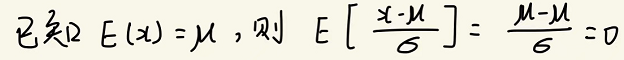

由于均值(期望)反映随机变量平均取值的大小，故当均值为0时，缺失值可以赋为0

*接下来处理离散值，用one-hot编码

先以MSZoning为例子理解下，“MSZoning”包含值“RL”和“Rm”。 将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。 根据独热编码，如果“MSZoning”的原始值为“RL”， 则：“MSZoning_RL”为1，“MSZoning_RM”为0。 

In [26]:
#MSZoning是第一个object类型的数据
all_features.select_dtypes('object').columns[0]

'MSZoning'

In [27]:
#查看MSZoning有哪几类
set(all_features['MSZoning'])

{'C (all)', 'FV', 'RH', 'RL', 'RM', nan}

In [28]:
#“Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

注：pandas中有one-hot编码的包

In [29]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


通过上面可以发现：特征的总数量从79个增加到331个

*前面将训练集和测试集加在了一起，接下来再将这两个分开。并运用values属性，从pandas格式中提取numpy格式，将其转换为张量用于训练。

In [30]:
n_train=train_data.shape[0]#训练集中数据量
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(
    train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

# 训练

In [39]:
in_features=train_features.shape[1]#特征数量
in_features

331

模型

In [38]:
def get_net():
    #线性模型
    net=nn.Sequential(nn.Linear(in_features,1))
    #全连接层在Linear类中定义，第一个指定输入特征形状，第二个指输出特征形状
    return net

误差（损失）

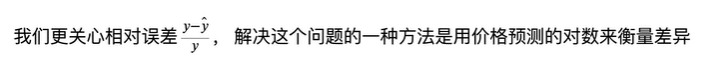
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：
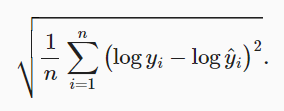

In [36]:
loss=nn.MSELoss()# 均方差损失函数

In [40]:
def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    #这里是控制结果范围为（1，正无穷），也就是小于1的会被转化成1
    rmse=torch.sqrt(loss(torch.log(clipped_preds),
                        torch.log(labels)))
    #torch.sqrt函数——逐元素计算张量的平方根
    return rmse.item()

训练

In [53]:
def train(net,train_features,train_labels,test_features,test_labels,
         num_epochs,learning_rate,weight_decay,batch_size):
    ##定义两个list类型存储每次周期迭代后的损失，以便监听训练过程
    train_ls,test_ls=[],[]
    
    ##数据读入
    train_iter=d2l.load_array((train_features,train_labels),batch_size)
    #load_array这个函数的作用是构造pytorch数据迭代器，可以根据batch_size逐步读入数据
    
    ##使用Adam优化算法
    optimizer=torch.optim.Adam(net.parameters(),#从模型中获得指定优化参数
                              lr=learning_rate,#学习率
                              weight_decay=weight_decay)#权值衰退
     
    ##小批量处理数据，运行多个迭代周期（由num_epochs指定)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()#启用梯度
            l=loss(net(X),y)#通过调用net(x)生成预测并计算损失l(前向传播)
            l.backward()#通过进行反向传播来计算梯度
            optimizer.step()#调用优化器更新模型
        train_ls.append(log_rmse(net,train_features,train_labels))#为了更好衡量训练效果，计算每次迭代周期后的损失
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

# K折交叉验证

有助于模型选择和超参数调整

首先需要定义一个函数，在K折交叉验证过程中返回第i折的数据。 具体地说，它选择第i个切片作为验证数据，其余部分作为训练数据。 注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [47]:
def get_k_fold_data(k,i,X,y):
    assert k > 1
    fold_size=X.shape[0]//k#整数除法,返回商的整数部分(向下取整)
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)#slice() 函数实现切片对象，主要用在切片操作函数里的参数传递。
        X_part,y_part=X[idx,:],y[idx]
        if j==i:#选择第i个切片为验证集
            X_valid,y_valid=X_part,y_part#验证集
        elif X_train is None:
            X_train,y_train=X_part,y_part#训练集
        else:
            X_train=torch.cat([X_train,X_part],0)
            y_train=torch.cat([y_train,y_part],0)
    return X_train,y_train,X_valid,y_valid

# 在k折交叉验证中训练k次后，返回训练和验证误差的平均值

In [55]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,
          batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,
                                weight_decay,batch_size)
        train_l_sum +=train_ls[-1]
        valid_l_sum +=valid_ls[-1]
        #train函数返回的是训练和验证损失数组，数组中每个元素是每一轮计算的损失。这里-1代表只取最后一轮损失
        if i==0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],
                    xlabel='epoch',ylabel='rmre',xlim=[1,num_epochs],
                    legend=['train','valid'],yscale='log')
        print(f'折{i+1},训练损失log rmse:{float(train_ls[-1]):f},'
             f'验证损失log rmse:{float(valid_ls[-1]):f}')
    return train_l_sum/k,valid_l_sum/k

# 模型选择

超参数解释：

k k折线中的k值，一般取5或10

num_epochs 迭代周期

lr 学习率，随机梯度下降每一步更新的大小

weight_decay 权值衰退

batch_size 批量大小，用于规范化步长

折1,训练损失log rmse:0.170412,验证损失log rmse:0.156730
折2,训练损失log rmse:0.162432,验证损失log rmse:0.189561
折3,训练损失log rmse:0.163683,验证损失log rmse:0.168376
折4,训练损失log rmse:0.167446,验证损失log rmse:0.154606
折5,训练损失log rmse:0.162970,验证损失log rmse:0.182674
5-折验证: 平均训练log rmse: 0.165389, 平均验证log rmse: 0.170389


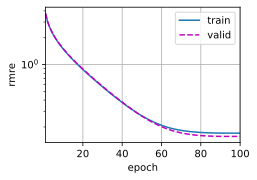

In [56]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

上面是指定参数教材里指定的参数，下面自己调调看

折1,训练损失log rmse:0.872645,验证损失log rmse:0.882985
折2,训练损失log rmse:0.871903,验证损失log rmse:0.885159
折3,训练损失log rmse:0.870768,验证损失log rmse:0.885917
折4,训练损失log rmse:0.877620,验证损失log rmse:0.852919
折5,训练损失log rmse:0.873208,验证损失log rmse:0.877244
5-折验证: 平均训练log rmse: 0.873229, 平均验证log rmse: 0.876845


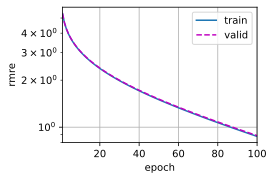

In [58]:
k,num_epochs,lr,weight_decay,batch_size=5,100,1,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1,训练损失log rmse:0.138112,验证损失log rmse:0.144114
折2,训练损失log rmse:0.135589,验证损失log rmse:0.150265
折3,训练损失log rmse:0.133450,验证损失log rmse:0.142143
折4,训练损失log rmse:0.138585,验证损失log rmse:0.141440
折5,训练损失log rmse:0.131705,验证损失log rmse:0.170207
5-折验证: 平均训练log rmse: 0.135488, 平均验证log rmse: 0.149634


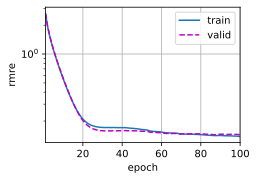

In [60]:
k,num_epochs,lr,weight_decay,batch_size=5,100,15,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1,训练损失log rmse:0.366592,验证损失log rmse:0.165156
折2,训练损失log rmse:0.185138,验证损失log rmse:0.648212
折3,训练损失log rmse:0.349045,验证损失log rmse:0.221260
折4,训练损失log rmse:0.360573,验证损失log rmse:0.156169
折5,训练损失log rmse:0.357146,验证损失log rmse:0.191858
5-折验证: 平均训练log rmse: 0.323699, 平均验证log rmse: 0.276531


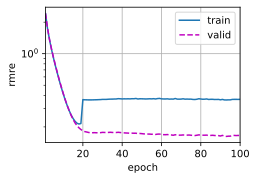

In [61]:
k,num_epochs,lr,weight_decay,batch_size=5,100,15,1,50
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1,训练损失log rmse:0.142837,验证损失log rmse:0.141393
折2,训练损失log rmse:0.138483,验证损失log rmse:0.173187
折3,训练损失log rmse:0.137138,验证损失log rmse:0.150323
折4,训练损失log rmse:0.142353,验证损失log rmse:0.140641
折5,训练损失log rmse:0.137460,验证损失log rmse:0.168123
5-折验证: 平均训练log rmse: 0.139654, 平均验证log rmse: 0.154733


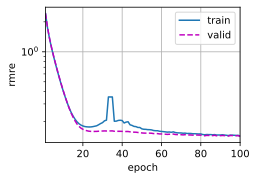

In [62]:
k,num_epochs,lr,weight_decay,batch_size=5,100,15,0.1,50
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1,训练损失log rmse:0.129407,验证损失log rmse:0.145915
折2,训练损失log rmse:0.125632,验证损失log rmse:0.145839
折3,训练损失log rmse:0.125580,验证损失log rmse:0.144177
折4,训练损失log rmse:0.130462,验证损失log rmse:0.137036
折5,训练损失log rmse:0.122457,验证损失log rmse:0.166468
5-折验证: 平均训练log rmse: 0.126708, 平均验证log rmse: 0.147887


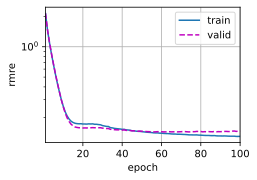

In [64]:
k,num_epochs,lr,weight_decay,batch_size=5,100,20,0.001,50
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1,训练损失log rmse:0.123673,验证损失log rmse:0.182839
折2,训练损失log rmse:0.116274,验证损失log rmse:0.176290
折3,训练损失log rmse:0.116389,验证损失log rmse:0.166187
折4,训练损失log rmse:0.123667,验证损失log rmse:0.163252
折5,训练损失log rmse:0.110145,验证损失log rmse:0.164859
5-折验证: 平均训练log rmse: 0.118029, 平均验证log rmse: 0.170686


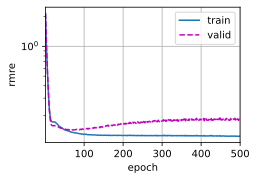

In [65]:
k,num_epochs,lr,weight_decay,batch_size=5,500,20,0.001,50
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1,训练损失log rmse:0.130315,验证损失log rmse:0.150839
折2,训练损失log rmse:0.131817,验证损失log rmse:0.117778
折3,训练损失log rmse:0.132144,验证损失log rmse:0.128749
折4,训练损失log rmse:0.127598,验证损失log rmse:0.158959
折5,训练损失log rmse:0.126166,验证损失log rmse:0.161891
折6,训练损失log rmse:0.131412,验证损失log rmse:0.118076
折7,训练损失log rmse:0.133106,验证损失log rmse:0.130077
折8,训练损失log rmse:0.131025,验证损失log rmse:0.139281
折9,训练损失log rmse:0.125432,验证损失log rmse:0.187204
折10,训练损失log rmse:0.131294,验证损失log rmse:0.139333
10-折验证: 平均训练log rmse: 0.130031, 平均验证log rmse: 0.143219


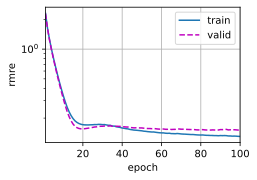

In [70]:
k,num_epochs,lr,weight_decay,batch_size=10,100,15,0,50
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                       weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 提交Kaggle预测

In [71]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.128794


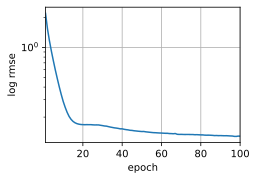

In [72]:
k,num_epochs,lr,weight_decay,batch_size=10,100,15,0,50
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)